### Description
- Investigate prediction differences between labels at time 0 and 24hr
- Only 318 observations with differences >= 0.3

Check
1. Diagnosis
2. Medications
3. Vital trend
4. Lab trend, esp. glucose

Inputs: all from 3.1_notebook
- `1_4_cohort_diff_full_features`: under modelfir4 (or modeldir4preadmit)
    - feature_type with the first letter capitalized is for order counts such as Lab
    - feature_type with all lowercase is for actual values: demo, vitals, and labs
    - gender = 1 is for female
- `1_4_cohort_test_results`: under modeldir4 (or modeldir4preadmit) WITH prediction results
- `1_4_cohort_full_features`: under modeldir4
(- `1_4_cohort_24hrpreadmit_full_features`: under featuredir, all cohort with all features within 24hr prior to admit_time)

Notes:
- prediction results did not change using either one of those 2 sets of obeservation: meaning add
- the small cohort might be slightly different. will look further into this

In [1]:
library(caret) # import this before glmnet to avoid rlang version problem
library(data.table)
library(tidyverse)
library(lubridate)
library(Matrix)
library(glmnet)
library(bit64)
library(pROC)
library(rms)

Loading required package: lattice

Loading required package: ggplot2

Warning message:
"package 'ggplot2' was built under R version 4.0.5"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, inte

In [2]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"
# modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"

# display rows and cols
options(repr.matrix.max.rows=250, repr.matrix.max.cols=30)

In [3]:
coh_diff <- read.csv(file.path(modeldir4, '1_4_cohort_diff_full_features.csv'))
nrow(coh_diff) #71689 vs 69334 for the updated obs
coh_diff <-  coh_diff %>% mutate(admit_time = ymd_hms(admit_time), time =  ymd_hms(time))
colnames(coh_diff)

coh_diff %>% group_by(feature_type) %>% summarise(n = n()) %>% arrange(n)

[1] 71689

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "abs_diff0_24"            "diff0_True"             
[11] "diff24_True"             "feature_type"           
[13] "features"                "values"                 
[15] "time"                    "hr_before_admit"

`summarise()` ungrouping output (override with `.groups` argument)



feature_type,n
<chr>,<int>
Microbiology,206
Procedures,513
Imaging,1837
demo,5491
Lab,6357
Meds,12453
vitals,12513
labs,12802
Diagnosis,19517


Scale for 'x' is already present. Adding another scale for 'x', which will
replace the existing scale.

Scale for 'y' is already present. Adding another scale for 'y', which will
replace the existing scale.



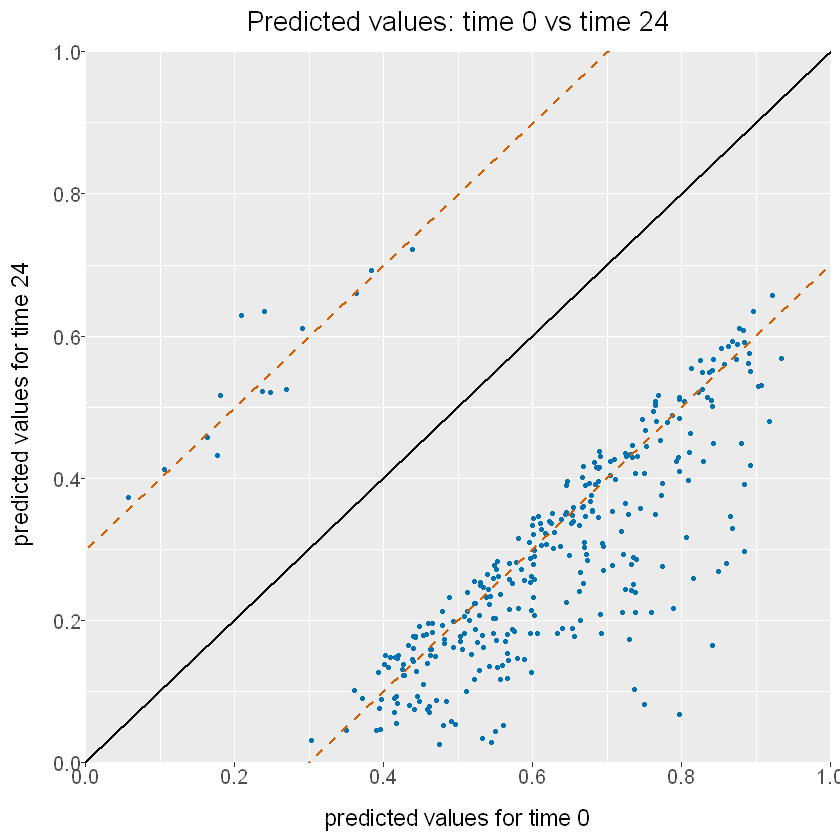

In [4]:
options(repr.plot.width=7, repr.plot.height=7)

ggplot(coh_diff, aes(x=pred_first, y=pred_death_24hr_recent)) + 
    geom_point(color = "#0072B2", size = 1) + xlim(0,1) + ylim(0,1) +
    geom_abline(intercept = 0, slope = 1, size = 0.7) +
    geom_abline(intercept = 0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    geom_abline(intercept = -0.3, slope = 1, size = 0.7, linetype=2, color = "#D55E00") +
    scale_x_continuous(name = "predicted values for time 0", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) + 
    scale_y_continuous(name = " predicted values for time 24", expand = c(0, 0), limits=c(0, 1), 
                       breaks=c(0, 0.2, 0.4, 0.6, 0.8, 1)) +
    theme(axis.text=element_text(size=12),
          axis.text.x = element_text(margin=margin(0, 0, 10, 0)),
          axis.text.y = element_text(margin=margin(0, 0, 0, 10)),
          plot.title = element_text(size=16, hjust=0.5, margin=margin(0, 0, 10, 0)),
          axis.title=element_text(size=14)) +
     labs(title = "Predicted values: time 0 vs time 24")


### Check most difference first
- 0.7 or more: 3
- 0.6 or more: 10
- 0.5 or more: 37

These observations include those who transferred and those who didn't.

Difference scenarios:
- 1st label != 24hr label: (transfers)
    - both predicted correctly or close enough
    - one wrong and one right
- 1st label == 24hr label: (same)
    - both predicted correctly or close enough
    - one wrong and one right
    
With the intention to check `model output differences`, all of the read-in data: 
- there is a huge difference btwn the 2 predicted outputs
- regardless whether 1st label != or == 24hr label

With the intention to investigate those who transferred, we are interested in the subgroup where *1st label != 24hr label*

Note that the same model architecture was used with 2 different labels. Binary threshold from the triage paper was 0.6

In [5]:
# count features and csn
diff <- coh_diff %>% 
            group_by(abs_diff0_24) %>% 
            summarise(nrows = n(), count_csn = n_distinct(pat_enc_csn_id_coded), count_mrn = n_distinct(anon_id)) %>% 
            arrange(-abs_diff0_24) %>% mutate(cum_csn = cumsum(count_csn), cum_mrn = cumsum(count_mrn))

diff

`summarise()` ungrouping output (override with `.groups` argument)



abs_diff0_24,nrows,count_csn,count_mrn,cum_csn,cum_mrn
<dbl>,<int>,<int>,<int>,<int>,<int>
0.7,561,3,3,3,3
0.6,1043,7,7,10,10
0.5,6561,27,24,37,34
0.4,19701,80,77,117,111
0.3,43823,206,204,323,315


### Check those with diff >= 0.5 first:
to get some insight before expanding 

In [6]:
d05 <- coh_diff %>% filter(abs_diff0_24 >= 0.5)
length(unique(d05$pat_enc_csn_id_coded))
length(unique(d05$anon_id)) # there's one anon_id in more than 1 group
nrow(d05)
colnames(d05)

[1] 37

[1] 33

[1] 8165

[1] "anon_id"                 "pat_enc_csn_id_coded"   
 [3] "admit_time"              "first_label"            
 [5] "death_24hr_recent_label" "death_24hr_max_label"   
 [7] "pred_first"              "pred_death_24hr_recent" 
 [9] "transfer"                "abs_diff0_24"           
[11] "diff0_True"              "diff24_True"            
[13] "feature_type"            "features"               
[15] "values"                  "time"                   
[17] "hr_before_admit"

### top CSNs
- top 3 vs 4 (diff >= 0.7): 131276655148, `131273666433`, 131271804263, 131265379414
- next 7 vs 10 (diff >= 0.6 and < 0.7): 
    - 131287638900, 131285560953, 131283367768, 131283156969, 131275893768, 131275001383, `131273666433`, 131273021618 (OLD)
    - 131287638900, 131285560953, 131283367768, `131278883571`, 131275001383, 131273021618, `131271881424`, `131268470191`, `131267990870`, `131266865289`

In [7]:
# top 4 csn
# as.list(distinct(coh_diff %>% filter(abs_diff0_24 >= 0.7) %>% select(pat_enc_csn_id_coded)) %>% arrange(-pat_enc_csn_id_coded))
csn1 <- sort(unique(coh_diff[coh_diff$abs_diff0_24 >= 0.7, ]$pat_enc_csn_id_coded))
csn1

# next 10 csn
csn2 <- sort(unique(coh_diff[coh_diff$abs_diff0_24 >= 0.6 &  coh_diff$abs_diff0_24 < 0.7, ]$pat_enc_csn_id_coded))
csn2

[1] 131265379414 131271804263 131276655148

[1] 131273021618 131273666433 131275001383 131275893768 131283156969
[6] 131283367768 131285560953

In [9]:
# only 1 bad predictions on time 24. other 3 are both good on both models
top1 <- d05 %>% filter(pat_enc_csn_id_coded %in% csn1)
nrow(top1) 

top1 %>% group_by(anon_id, pat_enc_csn_id_coded) %>% summarise(n=n())
top1 %>% group_by(pat_enc_csn_id_coded) %>% select(first_label, death_24hr_recent_label, transfer,
                                                   pred_first, pred_death_24hr_recent)%>% distinct()
 
# top1 %>% distinct(pat_enc_csn_id_coded, abs_diff0_24) %>% top_n(1)

[1] 561

`summarise()` has grouped output by 'anon_id'. You can override using the `.groups` argument.



anon_id,pat_enc_csn_id_coded,n
<chr>,<dbl>,<int>
JCd1a421,131265379414,109
JCd91ab7,131271804263,236
JCe6286a,131276655148,216


Adding missing grouping variables: `pat_enc_csn_id_coded`



pat_enc_csn_id_coded,first_label,death_24hr_recent_label,transfer,pred_first,pred_death_24hr_recent
<dbl>,<int>,<int>,<int>,<dbl>,<dbl>
131276655148,1,0,1,0.7492048,0.08195348
131271804263,1,0,1,0.8406619,0.16503982
131265379414,1,1,0,0.7969050,0.06790455


### Check how many were transfered:
- 19 out of 33 distinct anon_id, 22 csn out of 37 csn
- most from ICUs to non-ICUs & correct predictions, except for `JCdc9538`
- anon_id `JCd91ab7` appeared 3 times
- anon_id `JCe67809` appeared 2 times

In [10]:
nrow(d05 %>% filter(first_label != death_24hr_recent_label) %>% distinct(anon_id))

d05 %>% filter(first_label != death_24hr_recent_label) %>% 
            select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label, 
                   abs_diff0_24, pred_first, pred_death_24hr_recent) %>%
            arrange(anon_id, pat_enc_csn_id_coded) %>% distinct()# -abs_diff0_24, 

[1] 19

anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,abs_diff0_24,pred_first,pred_death_24hr_recent
<chr>,<dbl>,<dttm>,<int>,<int>,<dbl>,<dbl>,<dbl>
JC2a0f29b,131280435236,2020-01-11 11:08:00,1,0,0.5,0.7324723,0.27897978
JC2a1b145,131267727359,2019-04-20 13:19:00,1,0,0.5,0.8925185,0.41847357
JC2a31a2b,131273021618,2019-07-01 07:21:00,1,0,0.6,0.8841977,0.29646083
JCcc6f5a,131261651290,2019-01-27 21:31:00,1,0,0.5,0.7241807,0.24340748
JCceb298,131285560953,2020-03-06 04:21:00,1,0,0.6,0.7893417,0.21697571
JCcf7ee2,131261541119,2019-01-15 06:59:00,1,0,0.5,0.8834838,0.39151948
JCd2b078,131281836013,2020-02-05 06:40:00,1,0,0.5,0.6533526,0.18836503
JCd3262e,131275001383,2019-08-15 16:54:00,1,0,0.6,0.8597781,0.27967762
JCd91ab7,131271804263,2019-07-11 21:43:00,1,0,0.7,0.8406619,0.16503982


### Those who did not transfer:
- 14 (out of 33 mrn) or 15 out of 37 csn: from non-ICU to ICUs
- one label prediction is correct:  9 are for the 24hr label, 6 for time 0 label 
- for those with (0,0) labels at time 0 and 24: important to investigate these 2 below
    - `JCccaf40` (131278883571) and `JCe8eecd` (131287638900) has max label of 1
    - time 0 prediction leans toward 1. 
- anon_id JC2a1b3e1 appeared 2 times

In [12]:
nrow(d05 %>% filter(first_label == death_24hr_recent_label) %>% distinct(anon_id))

d05 %>% filter(first_label == death_24hr_recent_label) %>% 
            select(anon_id, pat_enc_csn_id_coded, admit_time, 
                   first_label, death_24hr_recent_label, death_24hr_max_label, transfer,
                   abs_diff0_24, pred_first, pred_death_24hr_recent) %>%
            arrange(anon_id, pat_enc_csn_id_coded) %>% distinct() #

[1] 14

anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,death_24hr_max_label,transfer,abs_diff0_24,pred_first,pred_death_24hr_recent
<chr>,<dbl>,<dttm>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,1,0,0.5,0.6918880,0.18118481
JC29fd236,131264662955,2019-02-11 11:54:00,0,0,0,0,0.5,0.6906416,0.20826471
JC29fe5a7,131273666433,2019-07-17 11:48:00,1,1,1,0,0.6,0.7369563,0.10290046
JC2a126ab,131275893768,2019-09-04 05:58:00,0,0,0,0,0.6,0.8152507,0.25902901
JC2a1306e,131271469230,2019-06-24 06:46:00,1,1,1,0,0.5,0.7394413,0.28618598
JC2a1b3e1,131266865289,2019-03-30 17:11:00,0,0,0,0,0.5,0.8686259,0.32946409
JC2a1b3e1,131271401201,2019-06-03 17:42:00,0,0,0,0,0.5,0.8650639,0.34595124
JCd1a421,131265379414,2019-03-21 13:11:00,1,1,1,0,0.7,0.7969050,0.06790455
JCd1ef38,131279807307,2019-11-19 03:56:00,0,0,0,0,0.5,0.8066095,0.31641917


In [13]:
results05 <- d05 %>% select(anon_id, pat_enc_csn_id_coded, admit_time, first_label, death_24hr_recent_label,
                            transfer, abs_diff0_24, feature_type, features, values, time) %>% 
                    mutate(transfer = ifelse(first_label != death_24hr_recent_label, 1, 0),
                           hr_before_admit = round(as.numeric(difftime(admit_time, time, unit="hours")), 1)) %>%
                    arrange(anon_id, admit_time, -abs_diff0_24)

In [14]:
results05 %>% filter(transfer==0) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% filter(transfer==0) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% head(10)

feature_type,n
<chr>,<int>
Diagnosis,1230
Meds,809
labs,574
vitals,516
Lab,335
demo,255
Imaging,68
Procedures,27
Microbiology,4


features,n
<chr>,<int>
DBP,122
RR,122
SBP,122
Pulse,114
Temp,36
Glucose,31
Hct,21
Hgb,21
K,19


In [15]:
results05 %>% filter(transfer==1) %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% filter(transfer==1) %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% head(10)

feature_type,n
<chr>,<int>
Diagnosis,1077
labs,1002
vitals,720
Meds,686
Lab,396
demo,374
Imaging,70
Procedures,16
Microbiology,6


features,n
<chr>,<int>
Pulse,165
DBP,161
SBP,161
RR,153
Temp,80
Glucose,69
K,46
Na,43
Hct,39


In [16]:
results05 %>% group_by(feature_type) %>% summarise(n=n()) %>% arrange(-n)
results05 %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n) %>% head(10)

feature_type,n
<chr>,<int>
Diagnosis,2307
labs,1576
Meds,1495
vitals,1236
Lab,731
demo,629
Imaging,138
Procedures,43
Microbiology,10


features,n
<chr>,<int>
DBP,283
SBP,283
Pulse,279
RR,275
Temp,116
Glucose,100
K,65
Na,62
Hct,60


,anon_id,pat_enc_csn_id_coded,admit_time,first_label,death_24hr_recent_label,transfer,abs_diff0_24,feature_type,features,values,time,hr_before_admit
,<chr>,<dbl>,<dttm>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dttm>,<dbl>
1,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0,0.5,vitals,Temp,37.2,2019-04-17 20:10:00,2.4
2,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0,0.5,vitals,DBP,95.0,2019-04-17 20:10:00,2.4
3,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0,0.5,vitals,DBP,85.0,2019-04-17 21:00:00,1.5
4,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0,0.5,vitals,DBP,73.0,2019-04-17 22:00:00,0.5
5,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0,0.5,vitals,Pulse,112.0,2019-04-17 20:10:00,2.4
6,JC29f8e61,131265730309,2019-04-17 22:32:00,1,1,0,0.5,vitals,Pulse,102.0,2019-04-17 21:00:00,1.5


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
  0.000   0.900   1.700   2.227   2.900  11.100    5353 

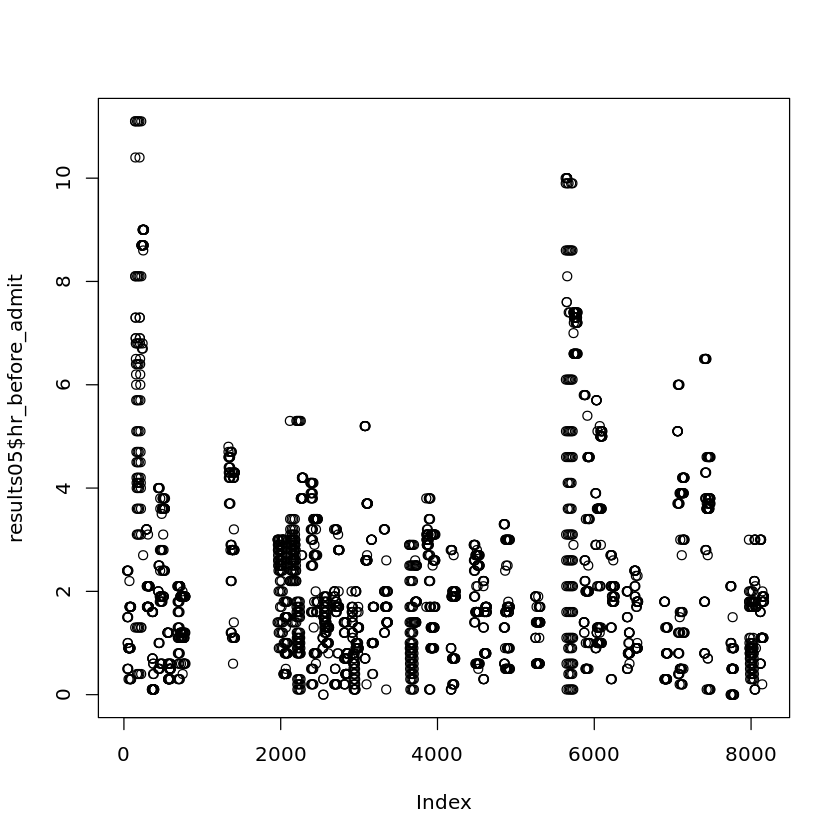

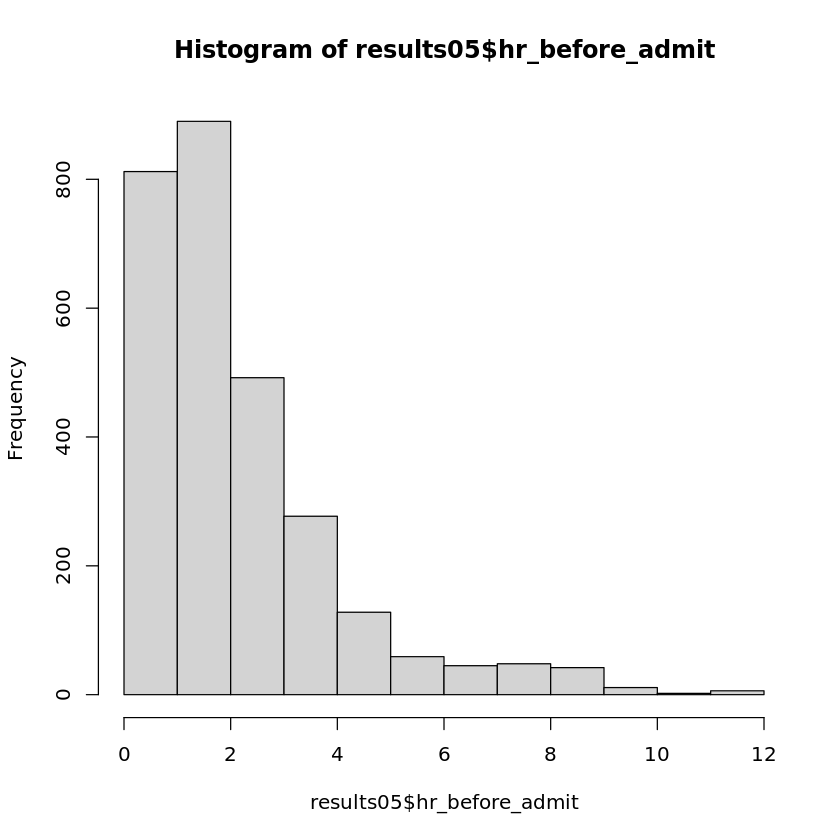

In [17]:
head(results05 %>% filter(feature_type == 'vitals'))
summary(results05$hr_before_admit)
plot(results05$hr_before_admit)
hist(results05$hr_before_admit)

In [18]:
results05_vsglu <- results05 %>% filter(feature_type=='vitals' | features=="Glucose") %>%
                    group_by(pat_enc_csn_id_coded, features, hr_before_admit) %>%
                    summarise(values=mean(values, na.rm=TRUE)) %>%
                    mutate(pat_enc_csn_id_coded = factor(pat_enc_csn_id_coded),
                           features = factor(features))
results05_vsglu %>% group_by(features) %>% summarise(n=n()) %>% arrange(-n)
head(results05_vsglu, 1)

`summarise()` has grouped output by 'pat_enc_csn_id_coded', 'features'. You can override using the `.groups` argument.



features,n
<fct>,<int>
DBP,248
SBP,248
Pulse,245
RR,243
Glucose,94
Temp,60


pat_enc_csn_id_coded,features,hr_before_admit,values
<fct>,<fct>,<dbl>,<dbl>
131261541119,DBP,0.2,60


Warning message:
“`fun.y` is deprecated. Use `fun` instead.”
`geom_smooth()` using method = 'loess' and formula 'y ~ x'



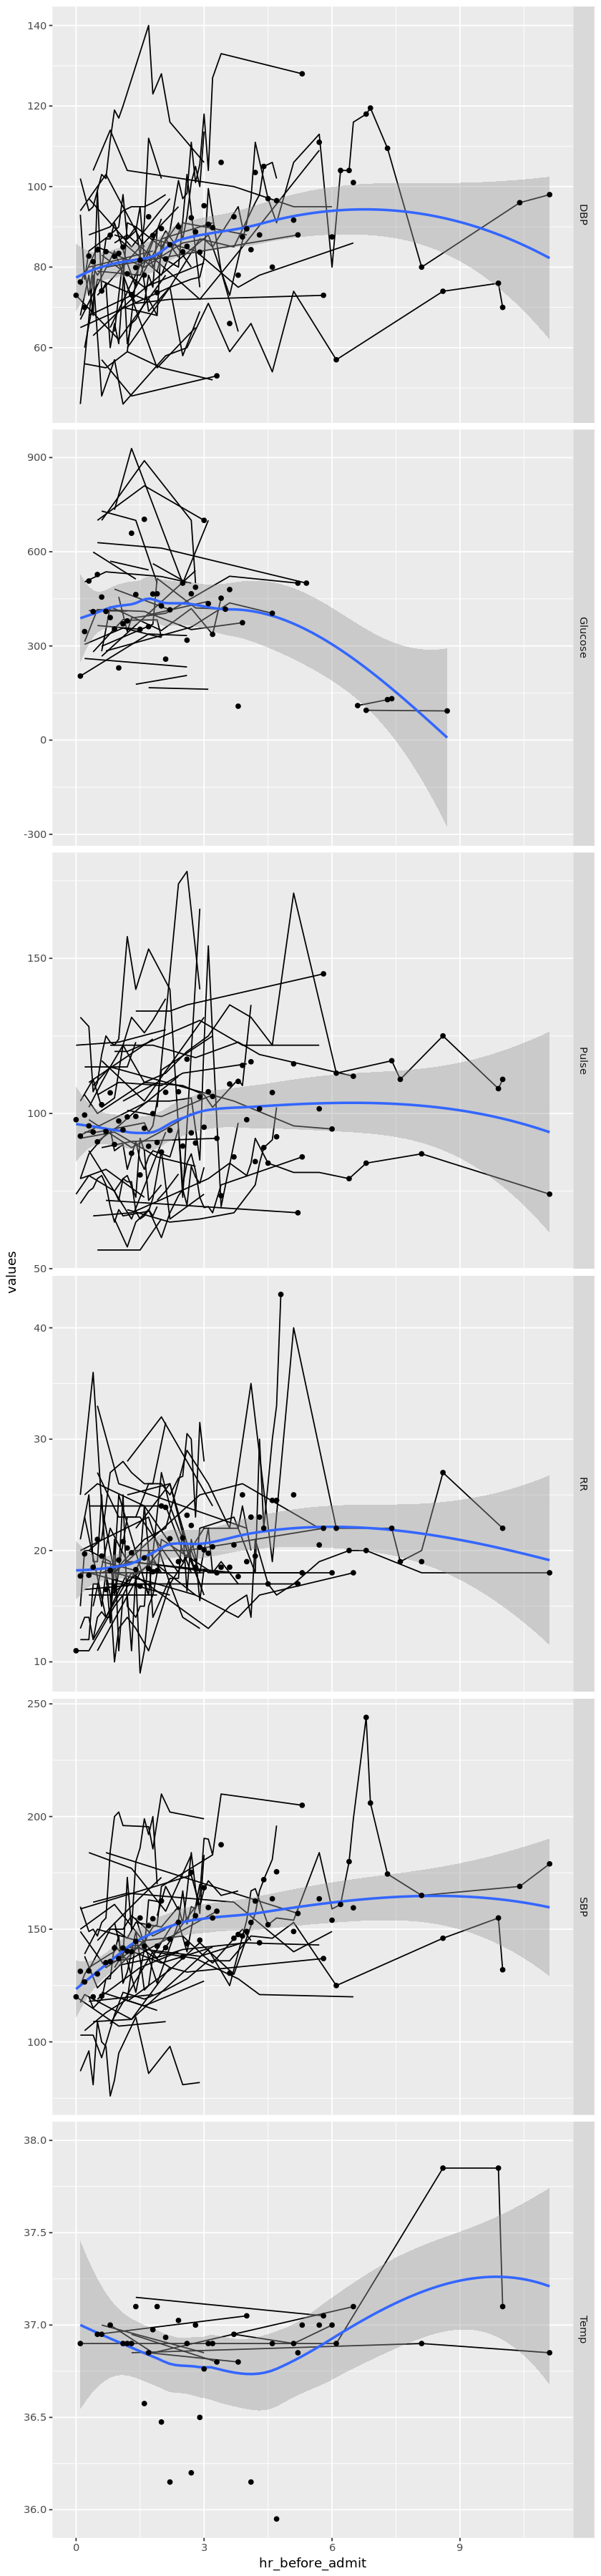

In [19]:
options(repr.plot.width=7, repr.plot.height=30)

# p <- ggplot(data = results05_vs, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(. ~ features)
# facet_wrap(. ~ features, scales="free_y") # cannot do facet_grid with free scale as above
p <- ggplot(data = results05_vsglu, aes(x = hr_before_admit, y = values, group = pat_enc_csn_id_coded)) + facet_grid(features ~ ., scales="free")

# use group 1 as for the whole data NOT per csn: so the smooth is not calculated separately for each csn
p + geom_line() + stat_smooth(aes(group = 1)) + stat_summary(aes(group = 1), geom = "point", fun.y = mean)

In [42]:
# results05 wide<- spread(results05, features, values)

### First obs:
- CSN: 131265379414
- first_label = death_24hr_recent_label = 1
- pred_first = 0.796905; pred_death_24hr_recent = 0.06790455 vs  0.7532933 & 0.06092662